 CCTV kameralarından alınan görüntülerle yangın duman ve normal durumu tespit eden bir yapay zeka modeli geliştirdim.
Amacım , bu modeli gerçek zamanlı güvenlik sistemlerine entegre ederek tehlikeleri erken fark etmek ve müdahale süresini azaltmak.
Veriler sabit görsellerden
Model eğitimi için iki farklı derin öğrenme mimarisi kullandım: MobileNetV2 ve EfficientNetB0.

In [1]:
# Data Science Kütüphaneleri

import numpy as np                # Sayısal işlemler için

import pandas as pd               # Veri analizi için

import matplotlib.pyplot as plt   # Grafik çizimi için

import tensorflow as tf           # Derin öğrenme için

from sklearn.model_selection import train_test_split  # Veri bölme işlemi için

from PIL import Image             # Görüntü işleme için

import cv2 as cv                  # OpenCV görüntü işleme kütüphanesi


# TensorFlow ve Keras

from tensorflow import keras      # Keras arayüzü

from tensorflow.keras import layers, models  # Katman ve model yapıları

from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Görüntü artırma

from tensorflow.keras.layers import Dense, Dropout  # Yoğun ve dropout katmanlar

from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint  # Eğitim kontrol araçları

from tensorflow.keras.optimizers import Adam  # Adam optimizasyon algoritması

from tensorflow.keras.applications import MobileNetV2  # Önceden eğitilmiş MobileNetV2 modeli

from tensorflow.keras import Model  # Özelleştirilmiş model sınıfı


# Sistem Kütüphaneleri

from pathlib import Path           # Dosya yolları için

import os                          # Sistem işlemleri için


# Değerlendirme Metrikleri

from sklearn.metrics import classification_report, confusion_matrix  # Performans ölçümü için

import itertools                  # Tekrarlı işlemler için


 حتى أتأكد من أن مجلد البيانات منظم بشكل صحيح، وأعرف كم صورة في كل فئة، وهل الصور بصيغة صحيحة أو لا.

In [2]:
from pathlib import Path  # Dosya yolları ile çalışmak için

import os                 # İşletim sistemi işlemleri için

# 1. Veri klasörünün yolunu belirleme 

# Proje klasörünüzde 'data' adlı bir klasör olduğundan emin olun; içinde train/ ve test/ klasörleri yer almalı

dataset_root = Path("/Users/macbook/Desktop/Fire Detection from CCTV/data")

#  2. Alt klasörleri dolaşma işlemi 

# Her klasörün ismi (yol), sınıf adı (son klasör ismi), içindeki görsel sayısı ve kullanılan uzantılar yazdırılacak

for root, dirs, files in os.walk(dataset_root):  # Klasörler içinde gezinme

    class_name = os.path.basename(root)  # Klasör ismini sınıf ismi olarak al

    if files:  # Eğer klasörde dosya varsa

        extensions = set(os.path.splitext(f)[1][1:] for f in files)  # Dosya uzantılarını topla

        print(f"Yol: {root}")  # Klasör yolunu yazdır

        print(f" → Sınıf: {class_name}")  # Sınıf ismini yazdır

        print(f" → Görüntü Sayısı: {len(files)}")  # Görüntü sayısını yazdır

        print(f" → Uzantılar: {extensions}\n")  # Dosya uzantılarını yazdır


Yol: /Users/macbook/Desktop/Fire Detection from CCTV/data
 → Sınıf: data
 → Görüntü Sayısı: 1
 → Uzantılar: {''}

Yol: /Users/macbook/Desktop/Fire Detection from CCTV/data/test/smoke
 → Sınıf: smoke
 → Görüntü Sayısı: 30
 → Uzantılar: {'jpg'}

Yol: /Users/macbook/Desktop/Fire Detection from CCTV/data/test/default
 → Sınıf: default
 → Görüntü Sayısı: 84
 → Uzantılar: {'jpg'}

Yol: /Users/macbook/Desktop/Fire Detection from CCTV/data/test/fire
 → Sınıf: fire
 → Görüntü Sayısı: 57
 → Uzantılar: {'jpg'}

Yol: /Users/macbook/Desktop/Fire Detection from CCTV/data/train
 → Sınıf: train
 → Görüntü Sayısı: 1
 → Uzantılar: {''}

Yol: /Users/macbook/Desktop/Fire Detection from CCTV/data/train/smoke
 → Sınıf: smoke
 → Görüntü Sayısı: 258
 → Uzantılar: {'jpg'}

Yol: /Users/macbook/Desktop/Fire Detection from CCTV/data/train/default
 → Sınıf: default
 → Görüntü Sayısı: 161
 → Uzantılar: {'jpg'}

Yol: /Users/macbook/Desktop/Fire Detection from CCTV/data/train/fire
 → Sınıf: fire
 → Görüntü Sayısı: 27

هذا الأسلوب يعطيني تحكم أكبر، خصوصًا إذا أردت لاحقًا استخدام tf.data.Dataset أو تحليل يدوي للبيانات أو إعادة التوازن بين الفئات.

In [ ]:
from pathlib import Path  # Dosya yolları ile çalışmak için

import os                 # İşletim sistemi işlemleri için

import pandas as pd       # Veri çerçevesi oluşturmak ve analiz etmek için


# 1. Ana görüntü klasörünün yolunu belirleme

# Klasör yapınız şu şekilde olmalı :
# data
# train
# default
# fire
# smoke
# test
# default
# fire
# smoke

dataset_dir = Path("/Users/macbook/Desktop/Fire Detection from CCTV/data")


# 2. Farklı uzantılardaki tüm görsellerin yollarını toplama

filepaths = (
    list(dataset_dir.glob("**/*.JPG")) +
    list(dataset_dir.glob("**/*.jpg")) +
    list(dataset_dir.glob("**/*.png"))
)


# 3. Her görüntünün üst klasöründen etiketleri (sınıfları) çıkarma

# p.parent.name dosyanın bulunduğu klasörün adını verir, bu da sınıf ismidir
labels = [p.parent.name for p in filepaths]

# 4. Görüntü yolları ve etiketlerden oluşan bir DataFrame oluşturma

image_df = pd.DataFrame({
    "filepaths": [str(p) for p in filepaths],  # Dosya yolunu string'e çevir
    "labels": labels
})


# 5. Verilerin doğru olduğundan emin olmak için son 5 satırı göster

image_df.tail(44) 


,filepaths,labels
820,/Users/macbook/Desktop/Fire Detection from CCT...,fire
821,/Users/macbook/Desktop/Fire Detection from CCT...,fire
822,/Users/macbook/Desktop/Fire Detection from CCT...,fire
823,/Users/macbook/Desktop/Fire Detection from CCT...,fire
824,/Users/macbook/Desktop/Fire Detection from CCT...,fire
825,/Users/macbook/Desktop/Fire Detection from CCT...,fire
826,/Users/macbook/Desktop/Fire Detection from CCT...,fire
827,/Users/macbook/Desktop/Fire Detection from CCT...,fire
828,/Users/macbook/Desktop/Fire Detection from CCT...,fire
829,/Users/macbook/Desktop/Fire Detection from CCT...,fire


In [4]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864 entries, 0 to 863
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  864 non-null    object
 1   labels     864 non-null    object
dtypes: object(2)
memory usage: 13.6+ KB


 تعرض صورًا عشوائية من البيانات مع الفئات الخاصة بها

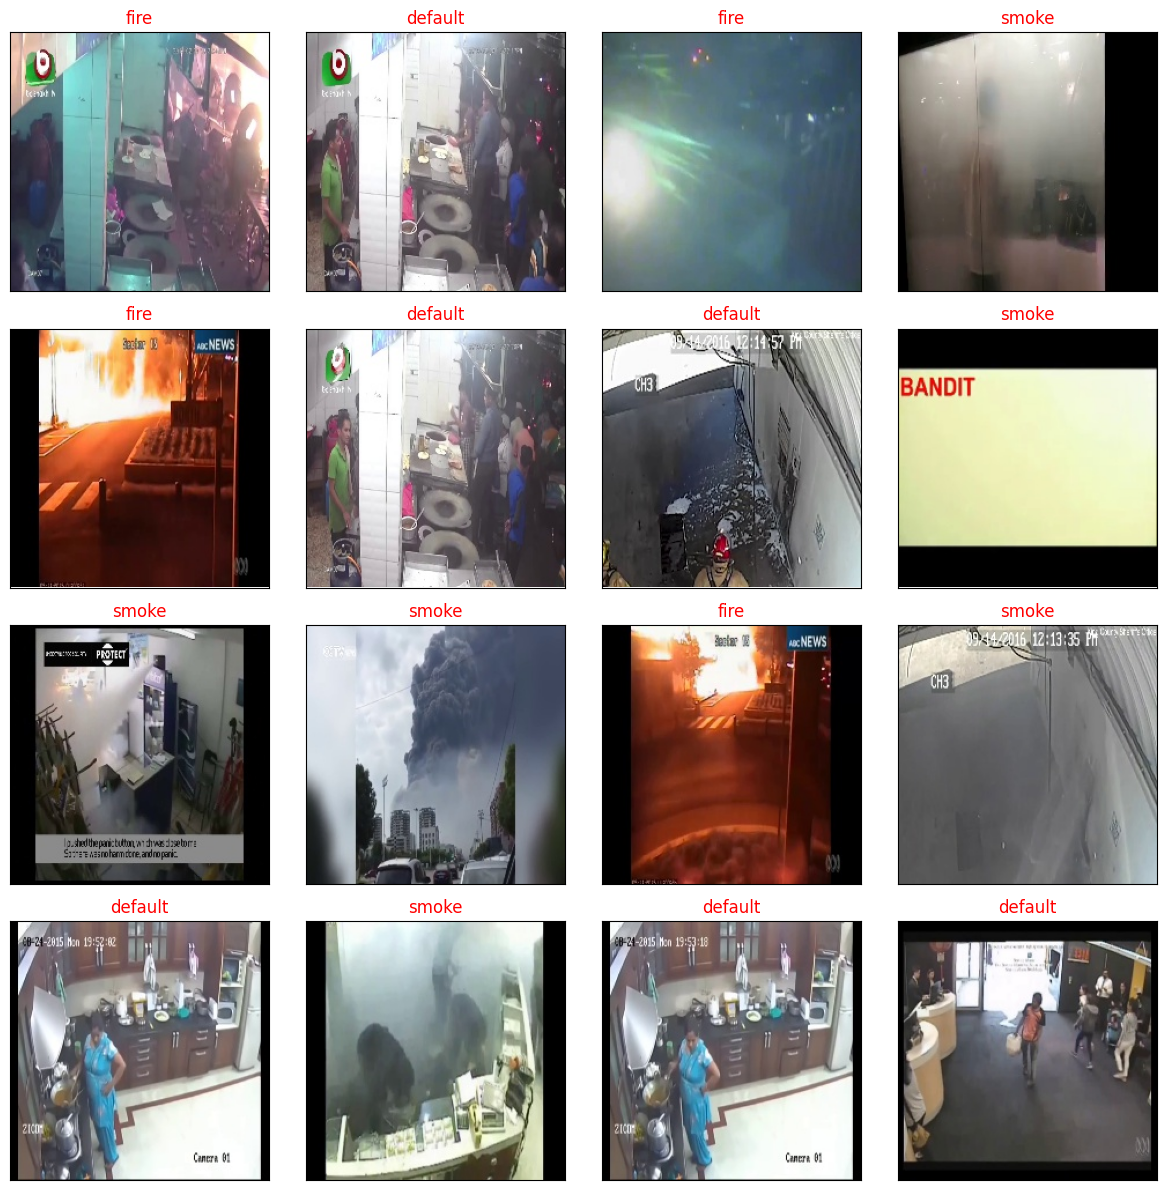

In [5]:
import numpy as np                # Sayısal işlemler ve rastgele seçimler için

import matplotlib.pyplot as plt   # Görselleştirme yapmak için

from PIL import Image             # Görüntü dosyalarını açmak için (PIL)


# DataFrame'den rastgele 16 görüntüyü ve etiketlerini görselleştir


# 1. [0 , satır sayısı) aralığında rastgele 16 indeks seç

random_indices = np.random.randint(0, len(image_df), 16)

# 2. 4 satır × 4 sütunluk bir grafik ağı oluştur

#    figsize şeklin boyutunu belirler (genişlik × yükseklik)

fig, axes = plt.subplots(4, 4, figsize=(12, 12),
                         subplot_kw={'xticks': [], 'yticks': []})

# 3. Her görüntüyü ve başlığını çizmek için döngü

for ax, idx in zip(axes.flat, random_indices):

    img_path = image_df.filepaths[idx]    # Görüntü dosyasının yolu

    label   = image_df.labels[idx]        # Etiket (default, fire, smoke)
    
    image = Image.open(img_path)          # Görüntüyü PIL ile aç

    ax.imshow(image)                      # Görüntüyü subplot üzerinde göster

    ax.set_title(label, color='red')      # Etiketi kırmızı renkte başlık olarak yaz

# 4. Boşlukları ayarla ve şekli göster

plt.tight_layout()
plt.show()


"في هذه الخطوة، قمت بتقسيم البيانات إلى 80% تدريب و20% اختبار باستخدام train_test_split.
فعّلت خاصية الخلط (shuffle=True) حتى تكون الفئات موزعة بشكل عادل، وثبتت العشوائية باستخدام random_state=42 لضمان أن كل مرة يعطي نفس النتيجة."

In [6]:
from sklearn.model_selection import train_test_split

# Verileri eğitim ve test gruplarına ayır

train_df, test_df = train_test_split(
    image_df,        # Görüntü yolları ve etiketleri içeren orijinal DataFrame

    test_size=0.2,   # Verilerin %20'si test grubu için ayrılır

    shuffle=True,    # Örneklerin çeşitliliğini sağlamak için verileri karıştır

    random_state=42  # Her çalıştırmada aynı sonucu almak için rastgelelik sabitlenir
)


"في هذه الخطوة حضرت الصور قبل إدخالها للنموذج. استخدمت ImageDataGenerator حتى أطبق المعالجة المسبقة الخاصة بـ MobileNetV2.
بالنسبة لبيانات التدريب، خصصت 20% منها للتحقق (validation) أثناء التدريب.
أما بيانات الاختبار، فحضرتها بنفس الطريقة ولكن بدون تقسيم

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Eğitim verisi için veri üretici (Train Data Generator)

train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    
    validation_split=0.2     # Eğitim verisinin %20'si doğrulama için ayrılır
)

# Test verisi için veri üretici (Test Data Generator)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    
    # Bu üretici sadece test verisi için kullanılır, bu yüzden validation_split kullanılmaz
)


In [ ]:

# 2. Eğitim verisi üreticisinin (Training Generator) oluşturulması

#    - train_df verisinin %80'i kullanılır

#    - 32 boyutunda görüntü grupları (batch) üretir

#    - Kategorik etiketler: ['default','fire','smoke'] (one-hot encoded)

train_images = train_generator.flow_from_dataframe(

    dataframe=train_df,               # Eğitim verisi için DataFrame

    x_col='filepaths',                # Görüntü dosya yolları

    y_col='labels',                   # Etiketler (default, fire, smoke)

    target_size=(224, 224),           # Görüntüler 224x224 boyutuna yeniden boyutlandırılır

    color_mode='rgb',                 # Renkli görüntüler (3 kanal)

    class_mode='categorical',         # Çok sınıflı sınıflandırma (3 sınıf)

    batch_size=32,                    # Batch boyutu

    shuffle=True,                     # Veriler rastgele karıştırılır

    seed=42,                          # Tekrarlanabilirlik için rastgelelik tohumu
    
    subset='training'                 # %80'lik eğitim alt kümesi seçilir
)



# 4. Test verisi üreticisinin (Test Generator) oluşturulması

#    test_df verisinin tamamı kullanılır
#    Sıralama korunur, karıştırma yapılmaz

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,                
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',         # Çok sınıflı sınıflandırma (3 sınıf)
    batch_size=32,
    shuffle=False                     # Test verileri karıştırılmaz
)


Found 553 validated image filenames belonging to 3 classes.
Found 173 validated image filenames belonging to 3 classes.


في هذا الجزء، استخدمت نموذج MobileNetV2 كقاعدة جاهزة من Google، لكن بدون الطبقات النهائية الأصلية.
اخترت include_top=False لأنني أريد أن أضيف طبقات تصنيف خاصة بي.
بعد ذلك، جمدت جميع طبقات النموذج حتى لا تتغير أثناء التدريب، لأن هدفنا هو الاستفادة من المعلومات التي تعلمها من قبل من بيانات ImageNet."

In [9]:
# Önceden eğitilmiş MobileNetV2 modelini üst katmanı olmadan (Top) yükleme

pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),     # Giriş görüntü boyutu: 224×224 piksel ve 3 renk kanalı (RGB)

    include_top=False,            # Üst katmanlar dahil edilmez, kendi sınıflandırma katmanlarımız eklenecek

    weights='imagenet',           # ImageNet veri kümesi üzerinde önceden eğitilmiş ağırlıklar kullanılır

    pooling='avg'                 # Çıkışta global average pooling uygulanır, tek boyutlu vektör üretir
)

# Önceden eğitilmiş modelin tüm katmanlarını dondurma (freeze)

for layer in pretrained_model.layers:
    layer.trainable = False       # Bu katmanların ağırlıkları eğitilebilir değildir (eğitim sırasında değişmeyecek)


In [10]:
from tensorflow.keras.layers import Dense, Dropout  # Yoğun katmanlar (Dense) ve aşırı öğrenmeyi önlemek için Dropout katmanı

from tensorflow.keras import Model                  # Model sınıfı, giriş ve çıkışları birleştirerek model oluşturmak için


# MobileNetV2 önceden eğitilmiş modelin üzerine yeni katmanlar ekleme


inputs = pretrained_model.input                     # Girişler, önceden eğitilmiş modelin girdi boyutu ile aynı olacak

x = Dense(256, activation='relu')(pretrained_model.output)  # 256 nöronlu ReLU aktivasyonlu bir tam bağlantılı katman ekleniyor

x = Dropout(0.2)(x)                                 # %20 oranında dropout uygulanarak overfitting riski azaltılır

x = Dense(256, activation='relu')(x)                # Aynı şekilde ikinci bir 256 nöronlu ReLU katmanı ekleniyor

x = Dropout(0.2)(x)                                 # Tekrar %20 dropout uygulanır

outputs = Dense(3, activation='softmax')(x)         # Çıkış katmanı: 3 sınıf için softmax aktivasyonu kullanılır (default, fire, smoke)

model = Model(inputs=inputs, outputs=outputs)       # Giriş ve çıkışları birleştirerek nihai modeli tanımlar

model.summary()                                     # Modelin katman yapısını ve parametre sayısını özet olarak gösterir


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,652,483 (10.12 MB)

 Trainable params: 394,499 (1.50 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 تُستخدم لحفظ أفضل نسخة من النموذج أثناء التدريب

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint  # Eğitim sırasında modelin en iyi ağırlıklarını kaydetmek için geri çağırma sınıfı

# Eğitim sırasında en iyi doğruluk değerine ulaşıldığında model ağırlıklarını kaydedecek bir Callback tanımlanıyor

checkpoint_path = "fires_classif_model.weights.h5"      # Kaydedilecek ağırlık dosyasının adı (.weights.h5 uzantısı olmalı)

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,         # Ağırlıkların kaydedileceği dosya yolu

    save_weights_only=True,           # Sadece ağırlıklar kaydedilecek, model mimarisi değil

    monitor="val_accuracy",           # Doğrulama (validation) doğruluğu izlenir
    
    save_best_only=True               # Sadece doğrulama doğruluğu iyileştiğinde ağırlıklar kaydedilir
)


"هنا استخدمت EarlyStopping حتى أتفادى التدريب الزائد (overfitting).
راقبت val_loss، وإذا لم يتحسن لمدة 5 epochs متتالية، يتم إيقاف التدريب تلقائيًا.
ولضمان الحفاظ على أفضل نسخة، فعّلت restore_best_weights=True لاسترجاع الأوزان الأفضل بعد التوقف."

In [12]:
from tensorflow.keras.callbacks import EarlyStopping  # Erken durdurma mekanizması için geri çağırma sınıfı (Callback)

# Eğitim sırasında doğrulama kaybı (val_loss) iyileşmediğinde modeli durdurmak için EarlyStopping tanımlanıyor

early_stopping = EarlyStopping(
    monitor="val_loss",           # Doğrulama kaybı (val_loss) izlenir
    patience=5,                   # 5 epoch boyunca iyileşme olmazsa eğitim durdurulur
    restore_best_weights=True     # Eğitim durduğunda en iyi ağırlıklar geri yüklenir
)


In [13]:
# Modeli derleme (compile) işlemi
model.compile(
    optimizer = Adam(0.0001),                # Öğrenme oranı 0.0001 olan Adam optimizasyon algoritması

    loss = 'categorical_crossentropy',       # Çok sınıflı sınıflandırma için uygun kayıp fonksiyonu

    metrics = ['accuracy']                   # Eğitim sırasında izlenecek başarı metriği: doğruluk (accuracy)
)

# Modeli eğitme (fit) işlemi
history = model.fit(
    train_images,                            # Eğitim verisi (veri jeneratörü)

    steps_per_epoch = len(train_images),     # Her epoch'ta işlenecek adım sayısı = toplam batch sayısı

    validation_data = val_images,            # Doğrulama verisi (validation set)

    validation_steps = len(val_images),      # Her epoch'ta yapılacak doğrulama adımı sayısı

    epochs = 100,                            # Maksimum epoch sayısı (erken durdurma varsa daha erken bitebilir)

    callbacks = [                            # Eğitim sırasında kullanılacak geri çağırmalar (callbacks)
        
        early_stopping,                      # Erken durdurma (val_loss iyileşmezse)

     #create_tensorboard_callback("training_logs" ,"fire_classification")
    
     # (isteğe bağlı) TensorBoard için kayıt callback'i

        checkpoint_callback,                 # En iyi ağırlıkları kaydeden geri çağırma
    ]
)


Epoch 1/100


/Users/macbook/Desktop/Fire Detection from CCTV/.venv312/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 285ms/step - accuracy: 0.4350 - loss: 1.1683 - val_accuracy: 0.7826 - val_loss: 0.7454
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 238ms/step - accuracy: 0.7303 - loss: 0.7202 - val_accuracy: 0.8768 - val_loss: 0.5139
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - accuracy: 0.7747 - loss: 0.5752 - val_accuracy: 0.9203 - val_loss: 0.3870
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 237ms/step - accuracy: 0.8737 - loss: 0.4145 - val_accuracy: 0.9130 - val_loss: 0.3110
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 242ms/step - accuracy: 0.8879 - loss: 0.3500 - val_accuracy: 0.9348 - val_loss: 0.2591
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - accuracy: 0.9112 - loss: 0.2881 - val_accuracy: 0.9275 - val_loss: 0.2285
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - accuracy: 0.9149 - loss: 0.2659 - val_accuracy: 0.9275 - val_loss: 0.2060
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 213ms/step - accuracy: 0.9460 - loss: 0.1917 - val_accuracy: 0.9348

In [21]:
def plot_loss_curves(history):
    loss = history.history['loss']                 # Eğitim kayıpları (loss) listesi

    val_loss = history.history['val_loss']         # Doğrulama (validation) kayıpları listesi


    accuracy = history.history['accuracy']         # Eğitim doğruluk (accuracy) değerleri listesi

    val_accuracy = history.history['val_accuracy'] # Doğrulama doğruluk (accuracy) değerleri listesi

    epochs = range(len(history.history['loss']))   # Epoch sayısı kadar bir sayı dizisi (x ekseni için)

    # Kayıp (loss) grafiğini çiz
    plt.figure(figsize =(10,4))                    # Şekil boyutunu ayarla

    plt.plot(epochs, loss, label='training_loss')  # Eğitim kayıplarını çiz

    plt.plot(epochs, val_loss, label='val_loss')   # Doğrulama kayıplarını çiz

    plt.title('Loss')                              # Başlık

    plt.xlabel('Epochs')                           # X ekseni etiketi

    plt.legend()                                   # Açıklama kutusu

    # Doğruluk (accuracy) grafiğini çiz
    plt.figure(figsize =(10,4))                    # Şekil boyutunu ayarla

    plt.plot(epochs, accuracy, label='training_accuracy')  # Eğitim doğruluk değerlerini çiz

    plt.plot(epochs, val_accuracy, label='val_accuracy')   # Doğrulama doğruluk değerlerini çiz

    plt.title('Accuracy')                          # Başlık

    plt.xlabel('Epochs')                           # X ekseni etiketi
    
    plt.legend();                                  # Açıklama kutusu


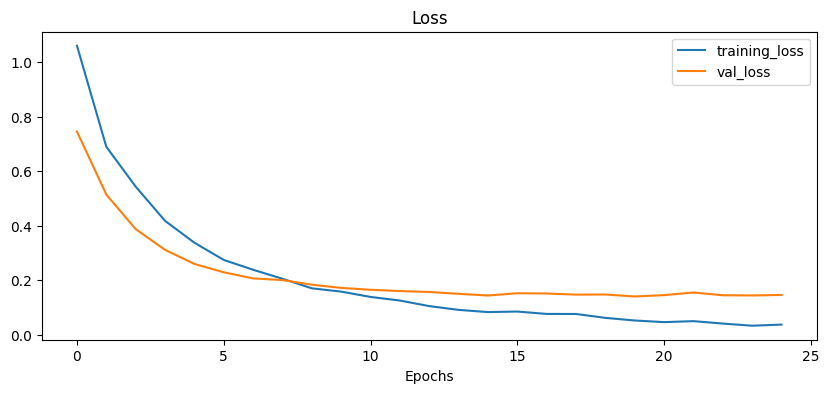

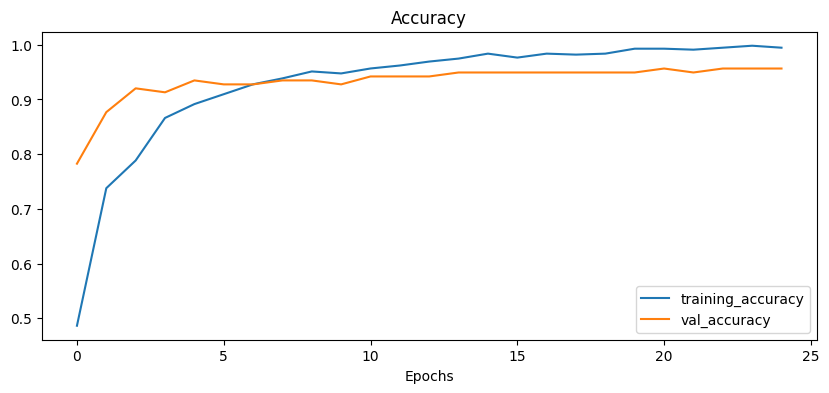

In [22]:
# Kayıp ve doğruluk eğrilerini görselleştir

plot_loss_curves(history)


In [23]:
# Test verisi üzerinde modeli değerlendir (kayıp ve doğruluk hesaplanır)

results = model.evaluate(test_images, verbose=0)

# Test kümesi için kayıp değeri (loss) yazdırılır

print("Test Loss: {:.5f}".format(results[0]))

# Test kümesi için doğruluk (accuracy) yüzdesi yazdırılır

print("Test Accuracy: {:.2f}%".format(results[1] * 100))


Test Loss: 0.09166
Test Accuracy: 95.95%


In [24]:
import numpy as np  # Sayısal işlemler ve dizi manipülasyonu için NumPy kütüphanesi

# 1. Modelin test verileri üzerindeki tahminlerini al

pred_probs = model.predict(test_images)  # Her görüntü için her sınıfa ait olasılık değerlerini içerir

pred_indices = np.argmax(pred_probs, axis=1)  # Olasılıklardan en yüksek olanın indeksi alınır → en muhtemel sınıf tahmini


# 2. Sınıf indekslerini sınıf isimlerine çevirmek için sözlük oluştur

class_to_index = train_images.class_indices  # Örneğin: {'default': 0, 'fire': 1, 'smoke': 2}

index_to_class = {index: label for label, index in class_to_index.items()}  # Sözlüğü ters çevir: {0: 'default', 1: 'fire', 2: 'smoke'}


# 3. İndeksleri sınıf etiketlerine çevir

pred_labels = [index_to_class[idx] for idx in pred_indices]  # Tahmin edilen sınıf isimleri listesi oluşturulur


# 4. İlk 5 tahmini ekrana yazdır

print(f'İlk 5 tahmin: {pred_labels[:5]}')  # İlk 5 tahmin edilen sınıf yazdırılır


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step
İlk 5 tahmin: ['smoke', 'fire', 'fire', 'smoke', 'smoke']


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step


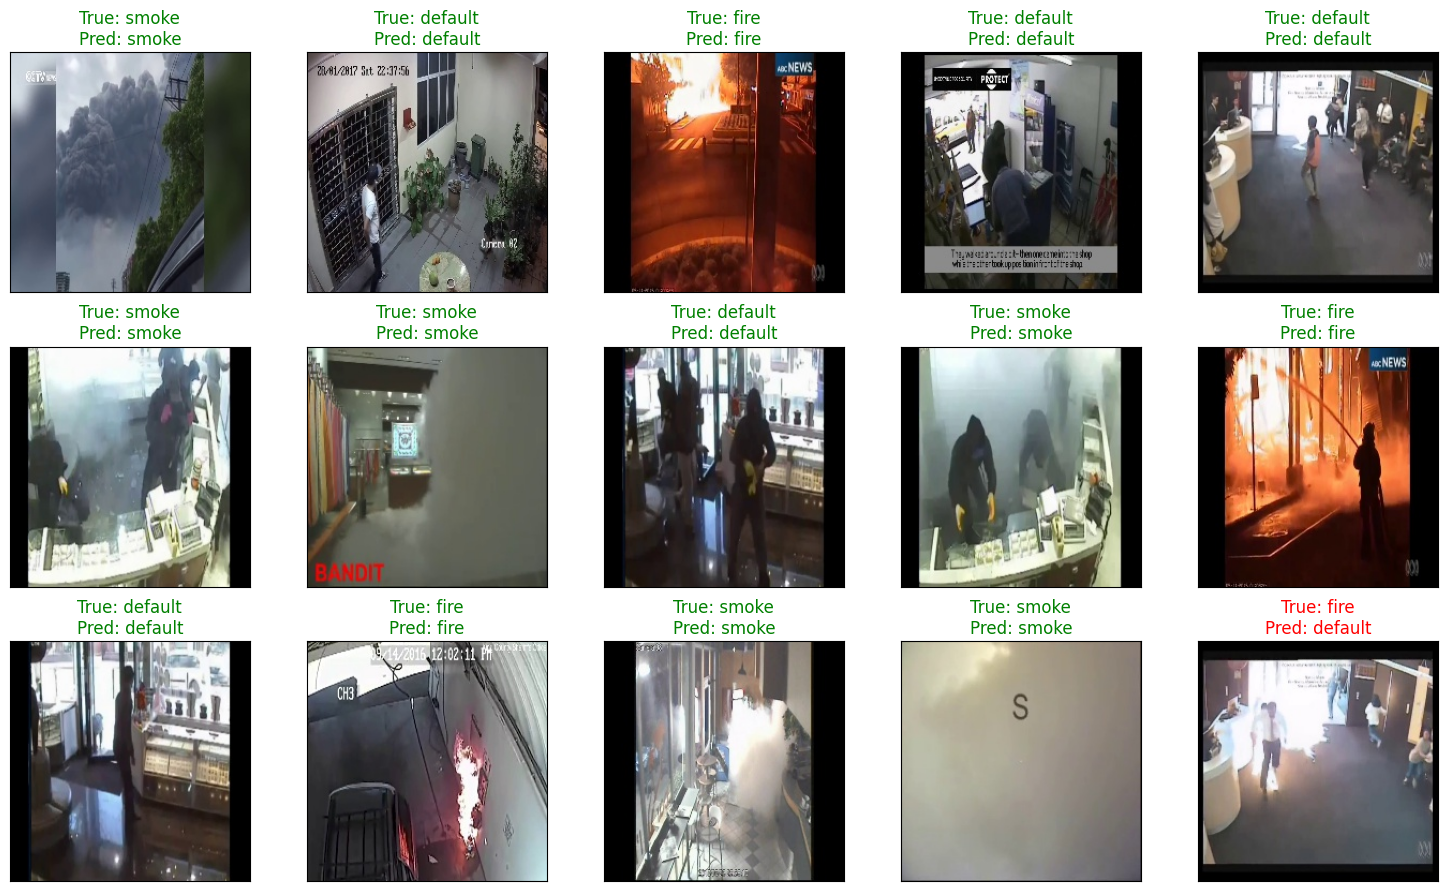

In [25]:
import numpy as np  # Sayısal işlemler için NumPy kütüphanesi

import matplotlib.pyplot as plt  # Görselleştirme işlemleri için matplotlib

from PIL import Image  # Görüntüleri açmak için PIL (Python Imaging Library)

# 1. Test verileri için model tahminlerini üret

pred_probs = model.predict(test_images)  # Her resim için sınıf olasılıklarını tahmin et

pred_indices = np.argmax(pred_probs, axis=1)  # En yüksek olasılığa sahip sınıfın indeksini al

index_to_class = {v: k for k, v in train_images.class_indices.items()}  # Sınıf indekslerini etiket isimlerine dönüştür

pred_labels = [index_to_class[idx] for idx in pred_indices]  # Tahmin edilen etiket isimlerini listele


# 2. Rastgele 15 test görüntüsünü etiketlerle birlikte görselleştir

random_indices = np.random.randint(0, len(test_df), size=15)  # 15 rastgele indeks seç

fig, axes = plt.subplots(3, 5, figsize=(15, 9),  # 3 satır, 5 sütun şeklinde çizim alanı oluştur
                         
                         subplot_kw={'xticks': [], 'yticks': []})  # Eksen işaretleri gizlenir

for ax, idx in zip(axes.flat, random_indices):
    img = Image.open(test_df.filepaths.iloc[idx])  # Görüntüyü dosya yolundan yükle

    ax.imshow(img)  # Görüntüyü eksen üzerinde göster
    
    true_label = test_df.labels.iloc[idx]  # Gerçek etiket

    pred_label = pred_labels[idx]  # Tahmin edilen etiket
    
    color = 'green' if true_label == pred_label else 'red'  # Doğru tahmin ise yeşil, yanlışsa kırmızı

    ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=color)  # Başlığı etiketlerle ayarla

plt.tight_layout()  # Grafiklerin birbirine karışmaması için boşlukları ayarla

plt.show()  # Grafiği göster


In [27]:
y_test = list(test_df.labels)  # Test veri kümesindeki gerçek etiketleri listeye dönüştür

print(classification_report(y_test, pred_labels))   # Sınıflandırma raporunu yazdır (Precision, Recall, F1-Score ve Destek sayısı içerir)


              precision    recall  f1-score   support

     default       0.92      0.96      0.94        49
        fire       0.99      0.96      0.97        69
       smoke       0.96      0.96      0.96        55

    accuracy                           0.96       173
   macro avg       0.96      0.96      0.96       173
weighted avg       0.96      0.96      0.96       173



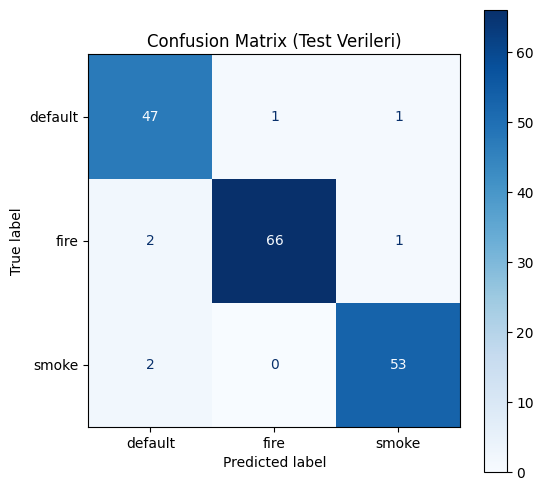

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # Karışıklık matrisi ve görselleştirmesi için

# 1. Gerçek etiketleri indeks biçiminde elde et (yani 0,1,2 olarak)

true_indices = [train_images.class_indices[label] for label in test_df.labels]  # Gerçek etiketlerin indeks karşılıkları

# 2. Karışıklık matrisini oluştur

cm = confusion_matrix(true_indices, pred_indices)  # confusion_matrix(y_true, y_pred)

# 3. Sınıf etiketlerini sıraya göre listele

class_names = list(train_images.class_indices.keys())  # ['default', 'fire', 'smoke']

# 4. Karışıklık matrisini çiz

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)  # Görselleştirme objesi oluştur

fig, ax = plt.subplots(figsize=(6,6))  # Grafik boyutunu belirle

disp.plot(cmap=plt.cm.Blues, ax=ax)  # Mavi renk paletiyle çizimi yap

plt.title("Confusion Matrix (Test Verileri)")  # Başlık

plt.show()  # Grafiği göster
